# INSTALL REQUIREMENTS

In [3]:
!pip install -r /kaggle/input/bd-requirements/bd_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.3 MB/s eta 0:00:0000:0100:01
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Obtaining dependency information for geopandas==0.13.2 from https://files.pythonhosted.org/packages/cb/7b/2fb6ab376c78d2e60812ad0bf4b24889309d2aeb543f54efcd586c69907f/geopandas-0.13.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.5 MB/s eta 0:00:0000:0100:01
  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 89.5 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for segmentation-models-pytorch==0.3.3 from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none

# IMPORTING LIBRARIES

In [28]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import math
import cv2
from tqdm.notebook import tqdm
from skimage import io, transform
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from PIL import Image
import xarray as xr
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

# GETTING FILE PATHS

In [22]:
def combine_files(image_path, label_path):
    files = {'image': image_path, 'mask': label_path}
    return files

def get_files(base_dir):
    subfolders = sorted(glob.glob(os.path.join(base_dir, '*')))
    files_list = []

    for subfolder in subfolders:
        images = sorted(glob.glob(os.path.join(subfolder, "images/*")))
        labels = sorted(glob.glob(os.path.join(subfolder, "labels_match/*")))
        
        # Assuming the number of images and labels is the same for each subfolder
        for image_path, label_path in zip(images, labels):
            files_list.append(combine_files(image_path, label_path))

    return files_list

1423
{'image': '/kaggle/input/spacenet-7-multitemporal-urban-development/SN7_buildings_train/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif', 'mask': '/kaggle/input/spacenet-7-multitemporal-urban-development/SN7_buildings_train/train/L15-0331E-1257N_1327_3160_13/labels_match/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'}


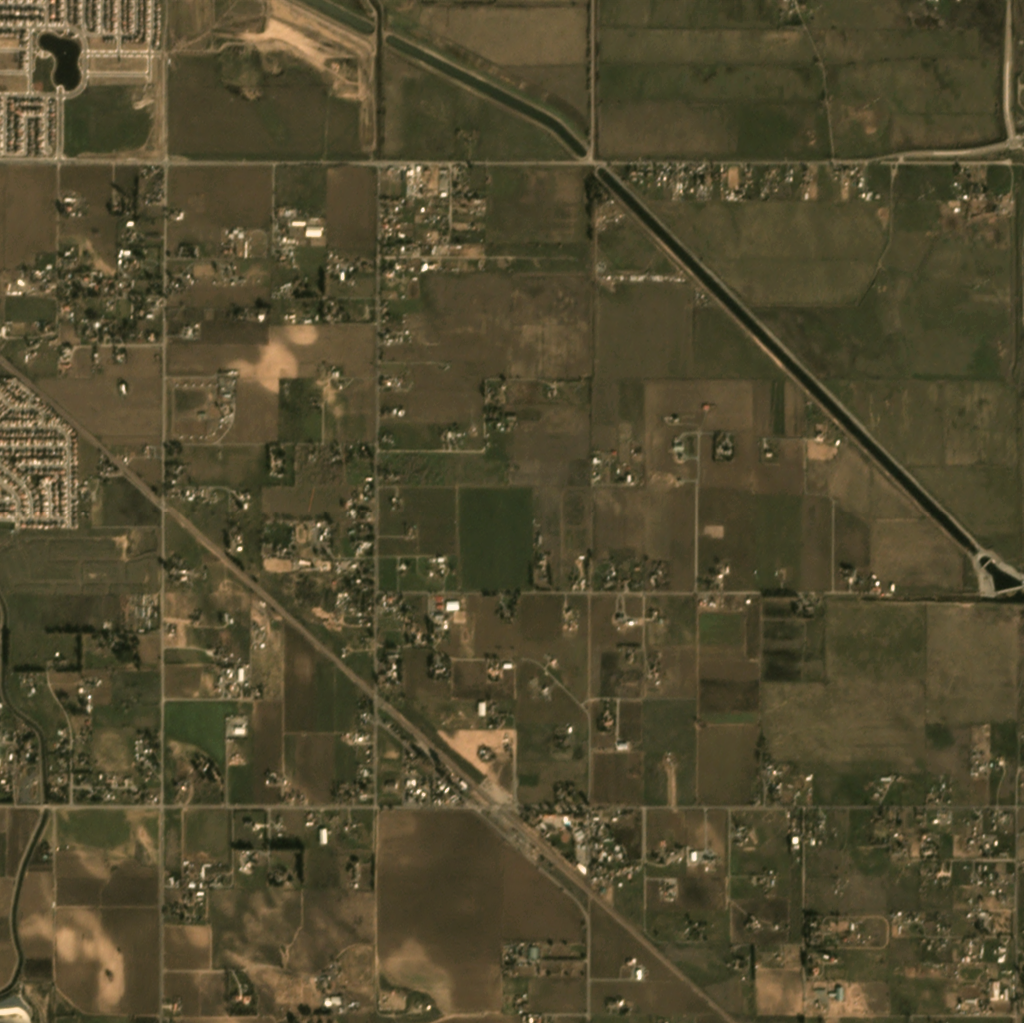

In [23]:
# Example usage
base_directory = "/kaggle/input/spacenet-7-multitemporal-urban-development/SN7_buildings_train/train"
files = get_files(base_directory)
print(len(files))
print(files[0])
img = Image.open(files[0]['image']).convert('RGB')
img

# SETTING UP DATALOADER

In [24]:
class SpaceNet7(Dataset):
  def __init__(self, files, tile_size, transforms_=None):
    self.files = files
    self.tile_size = tile_size
    self.transforms_ = transforms_

  def rasterize_geojson(self, idx):
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(self.files[idx]['mask'])
    # Open the reference raster using Rasterio
    with rio.open(self.files[idx]['image']) as raster:
      # Read the first band of the raster
      r = raster.read(1)
      # Reproject the GeoDataFrame to EPSG:3857
      gdf = gdf.to_crs('epsg:3857')
      # Initialize an empty mask with zeros
      mask = np.zeros_like(r, dtype=np.uint8)
      # Iterate over geometries and set corresponding values in the mask to 255
      for geom in gdf['geometry']:
        # Convert the geometry to the pixel coordinates in the reference raster
        geom_px = features.geometry_mask([geom], transform=raster.transform, out_shape=r.shape, invert=True)
        # Set the corresponding values in the mask to 1
        mask[geom_px] = 1
      return mask

  # gotten from https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
  def make_tiles(self, img, mask, tile_size=256):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    mask: np.ndarray with dtype np.uint9 and shape (width, height)
    '''
    w_i, h_i, ch = img.shape
    w_m, h_m = mask.shape

    pad0, pad1 = (tile_size - w_i%tile_size) % tile_size, (tile_size - h_i%tile_size) % tile_size

    padding_i = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    padding_m = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2]]

    img = np.pad(img, padding_i, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)

    mask = np.pad(mask, padding_m, mode='constant', constant_values=255)
    mask = mask.reshape(mask.shape[0]//tile_size, tile_size, mask.shape[1]//tile_size, tile_size)
    mask = mask.transpose(0, 2, 1, 3).reshape(-1, tile_size, tile_size)

    num_tiles = len(mask)
    return img, mask

  def __getitem__(self, idx):
    # read the images and masks as numpy arrays
    img = np.array(Image.open(self.files[idx]['image']).convert('RGB'))
    mask = self.rasterize_geojson(idx)
    if self.transforms_:
      aug = self.transforms_(image=img, mask=mask)
      img, mask = aug['image'], aug['mask']

    img, mask = self.make_tiles(img, mask, self.tile_size)
    #returns a random index from the tiled images
    ind = random.randint(0, len(img) - 1)
    img, mask = img[ind], mask[ind]

    img = img.transpose(2,1,0)
    img = torch.tensor(img, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.uint8)
    # Normalize the image tiles to the range [0, 1]
    img_tiles_normalized = (img - img.min()) / (img.max() - img.min())

    # normalize the images (image- image.mean()/image.std())
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

    # return img, mask
    return img_tiles_normalized, mask

  def __len__(self):
      return len(self.files)

In [31]:
tile_size = 256
batch_size = 16

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
#     A.Blur(blur_limit=3, p=0.5),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT)
    ],is_check_shapes = False)

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)

train_dataset = SpaceNet7(files=train_files, tile_size=tile_size, transforms_=train_transforms)
val_dataset = SpaceNet7(files=val_files, tile_size=tile_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'len train: {len(train_files)}')
print(f'len val: {len(val_files)}')

len train: 1138
len val: 285


# VISUALIZE THE DATALOADER

In [26]:
def visualize_loaded_tiles(img_tiles, mask_tiles):
    num_tiles, _, _, _ = img_tiles.shape
    rows = int(math.sqrt(num_tiles))
    cols = int(math.sqrt(num_tiles))

    plt.figure(figsize=(15, 15))
    # Display individual tiles with masks
    for i, tile in enumerate(img_tiles):
        plt.subplot(rows, cols, i + 1)
        tile = tile.permute(2,1,0)
        plt.imshow(tile)
        plt.imshow(mask_tiles[i], cmap='seismic', alpha=0.5)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Tile {i + 1}\nTile Size: {tile.shape}')
    plt.tight_layout()
    plt.show()

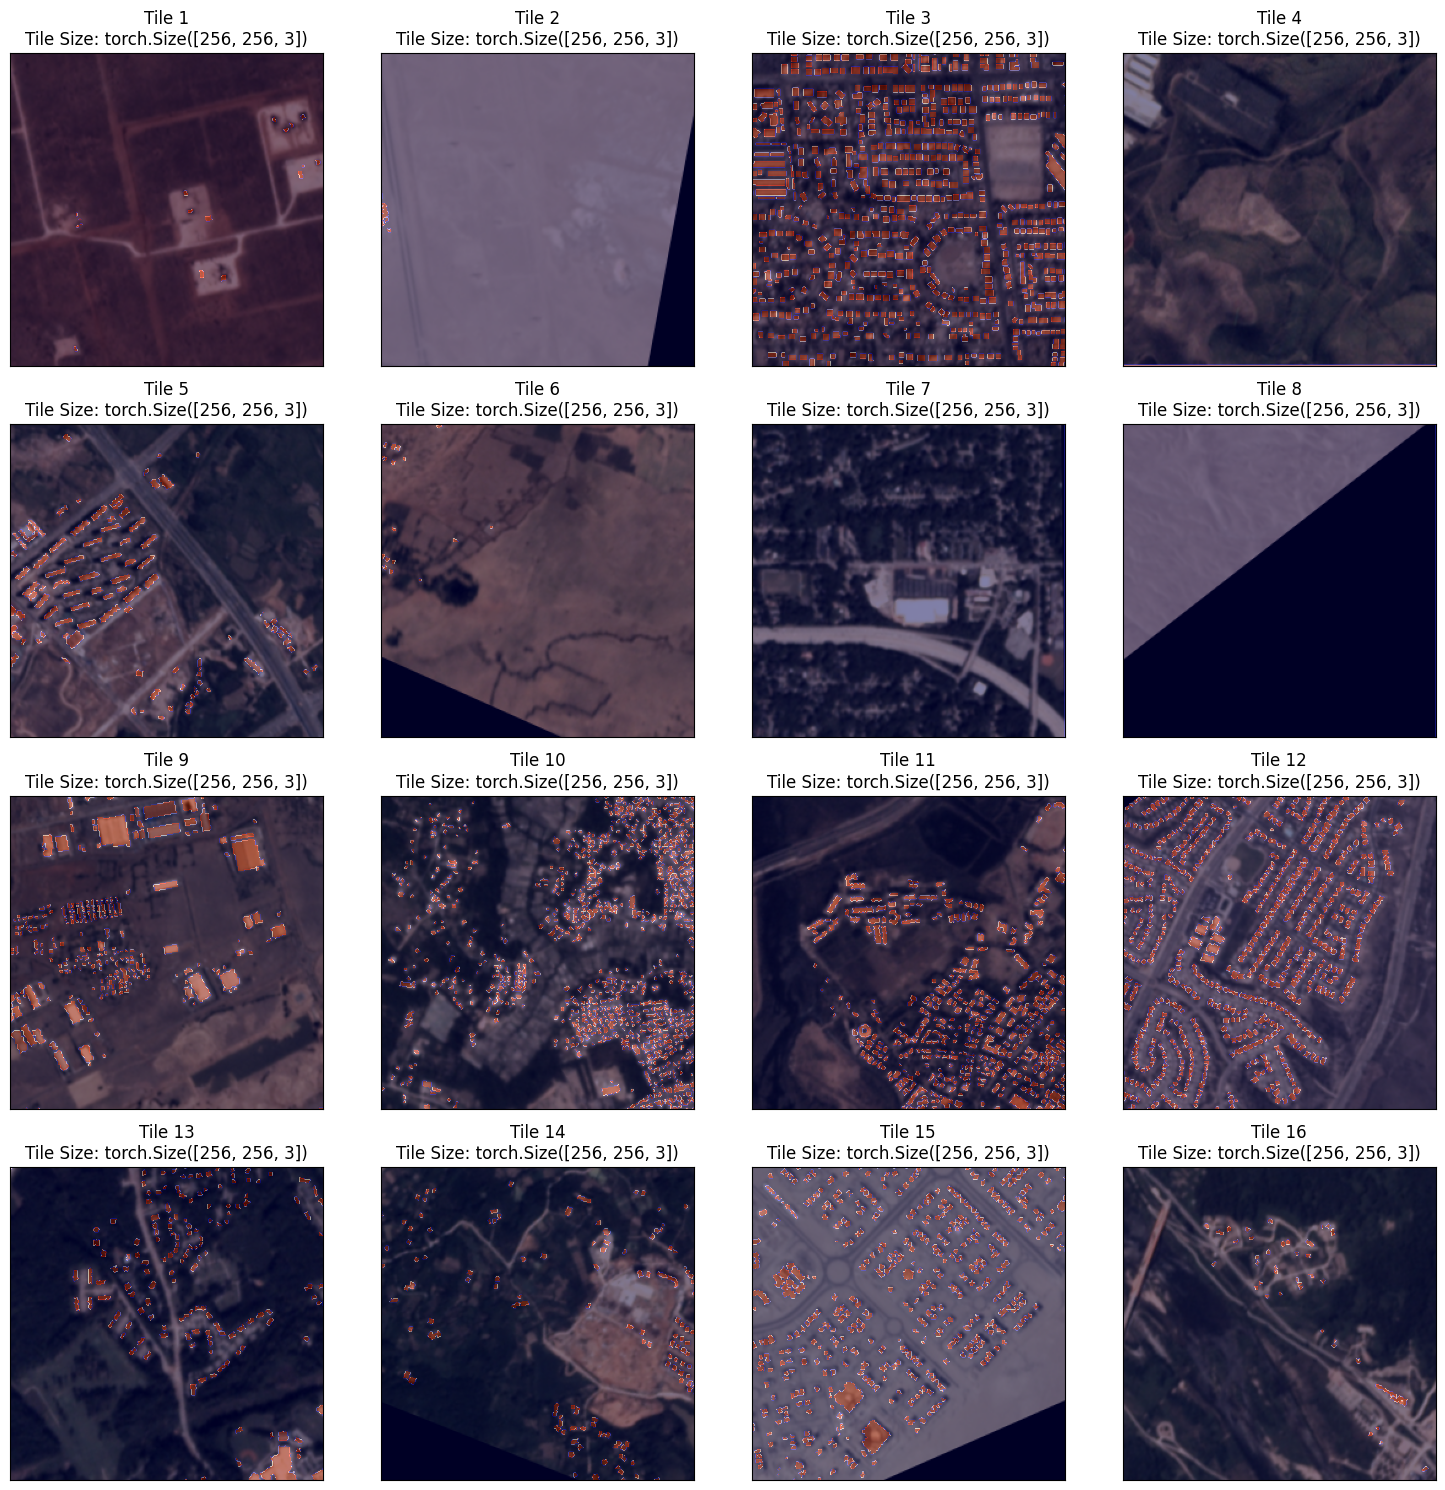

In [32]:
images, masks = next(iter(train_loader))
visualize_loaded_tiles(images, masks)

# MODEL BUILDING

In [34]:
class_size = 1
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,                      # model output channels (number of classes in your dataset)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


cpu


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [33]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch[0].to(device), batch[1].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch[0].to(device), batch[1].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
          
    return epoch_loss/num_batches, epoch_iou_score/num_batches

# MODEL TRAINING

In [ ]:
# EPOCHS = 50
EPOCHS = 3

logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('/kaggle/working/checkpoints') == False:
    os.mkdir("/kaggle/working/checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)


    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # On epoch end
    torch.save(model.state_dict(), "/kaggle/working/checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "/kaggle/working/checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/3 [00:00<?, ?it/s]

# MODEL EVALUATION

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()